In [138]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA

In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

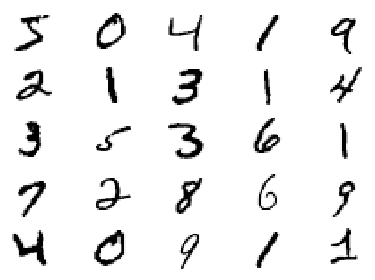

In [94]:
fig, ax_array = plt.subplots(5, 5)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [68]:
pca = PCA(n_components=2)

In [69]:
pca_train = pca.fit_transform(x_train.reshape(60000, -1))

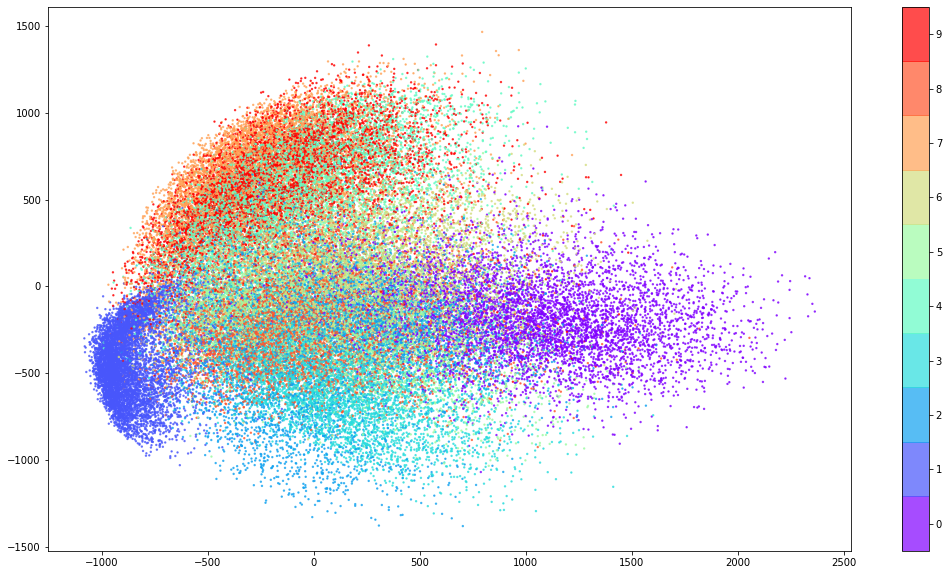

In [91]:
plt.figure(figsize=[18,10])
plt.scatter(pca_train[:,0], pca_train[:,1], c = y_train, cmap='rainbow', s=2, alpha = .7)
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))

In [92]:
pca.explained_variance_ratio_[-1]

0.07095924053861051

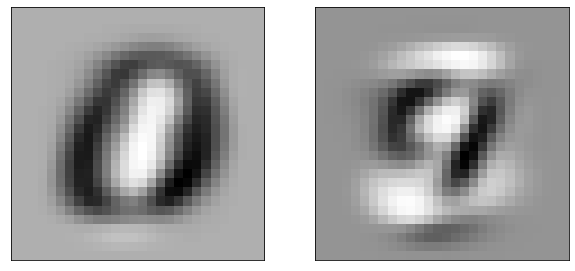

In [113]:
fig, ax_array = plt.subplots(1, 2, figsize=[10, 10])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(pca.components_[i].reshape(28,28), cmap='Greys')
plt.setp(axes, xticks=[], yticks=[]);

In [143]:
pca_nlabels = PCA(n_components=10)

In [144]:
pca_train = pca_nlabels.fit_transform(x_train.reshape(60000, -1))

In [145]:
pca_nlabels.explained_variance_ratio_[-1]

0.023569782304863642

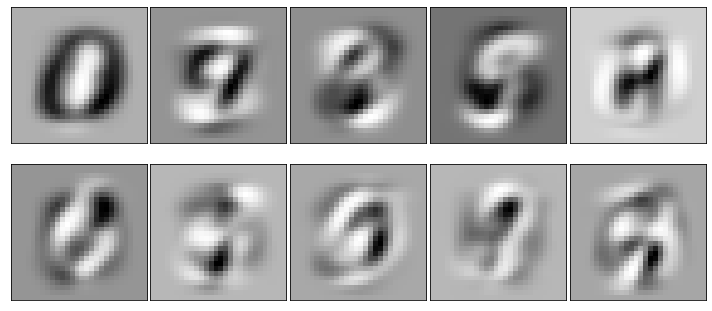

In [159]:
fig, ax_array = plt.subplots(2, 5, figsize=[10, 5])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(pca_nlabels.components_[i].reshape(28,28), cmap='Greys')
plt.setp(axes, xticks=[], yticks=[]);
plt.tight_layout(h_pad=0, w_pad=0.01)